# Import modules

In [1]:
from IPython.display import Image 

import os
import sys
import numpy as np
import pandas as pd
import netCDF4 as nc
import fiona
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm, ListedColormap
import matplotlib.image
from shapely import geometry
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.text as mtext
import matplotlib.font_manager as mfonts
import matplotlib as mpl
import pyproj
import cartopy.io.shapereader as shpreader
import cartopy.io.img_tiles as cimgt

import read_data, concatenation, radar

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Load data

In [3]:
date = '20140612'

In [4]:
p_gage = read_data.radar_to_panel('../data/data_{0}.nc'.format(date),
                                  'gage', dim_map={'lat' : 'latitude', 'lon' : 'longitude', 'time' : 'time'}, time_unit='ns')
p_radar = read_data.radar_to_panel('../data/data_{0}.nc'.format(date),
                                   'radar', dim_map={'lat' : 'latitude', 'lon' : 'longitude', 'time' : 'time'}, time_unit='ns')
p_veh = read_data.radar_to_panel('../data/data_{0}.nc'.format(date),
                                 'wiper', dim_map={'lat' : 'latitude', 'lon' : 'longitude', 'time' : 'time'}, time_unit='ns')
g = gpd.read_file('../data/cb_2014_us_ua10_500k.shp').query('NAME10 == "Ann Arbor, MI"')

In [5]:
veh = read_data.read_vehicle_data('../data/{0}.csv'.format(date))

# Process data

In [6]:
bbox = (p_radar.minor_axis.min(), p_radar.minor_axis.max(),
        p_radar.major_axis.min(), p_radar.major_axis.max())

gage_means = np.nanmean(p_gage.values[:, :, :], axis=0)
iy, ix = np.where((~np.isnan(gage_means)) & (gage_means > 0))
y = p_gage.major_axis[iy]
x = p_gage.minor_axis[ix]

v_iy, v_ix = np.where(~np.isnan(p_veh.mean(axis=0).values))
veh = veh[(veh['Longitude'] > bbox[0]) & (veh['Longitude'] < bbox[1])
    & (veh['Latitude'] > bbox[2]) &(veh['Latitude'] < bbox[3])]
v_g = veh.groupby(['Trip', pd.TimeGrouper('s')]).mean()

# Generate plot

In [7]:
bbox = (p_radar.minor_axis.min(), p_radar.minor_axis.max(),
        p_radar.major_axis.min(), p_radar.major_axis.max())

xmin, xmax, ymin, ymax = bbox

In [8]:
roads = gpd.read_file('../data/allroads_miv14a.shp')

In [9]:
def add_osgb_scalebar(ax, at_x=(0.1, 0.4), at_y=(0.05, 0.075), max_stripes=5, zorder=0):
    """
    Add a scalebar to a GeoAxes of type cartopy.crs.OSGB (only).

    Args:
    * at_x : (float, float)
        target axes X coordinates (0..1) of box (= left, right)
    * at_y : (float, float)
        axes Y coordinates (0..1) of box (= lower, upper)
    * max_stripes
        typical/maximum number of black+white regions
    """
    # ensure axis is an OSGB map (meaning coords are just metres)
    # assert isinstance(ax.projection, ccrs.OSGB)
    # fetch axes coordinate mins+maxes
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    # set target rectangle in-visible-area (aka 'Axes') coordinates
    ax0, ax1 = at_x
    ay0, ay1 = at_y
    # choose exact X points as sensible grid ticks with Axis 'ticker' helper
    x_targets = [x0 + ax * (x1 - x0) for ax in (ax0, ax1)]
    ll = mpl.ticker.MaxNLocator(nbins=max_stripes, steps=[1,2,4,5,10])
    x_vals = ll.tick_values(*x_targets)
    # grab min+max for limits
    xl0, xl1 = x_vals[0], x_vals[-1]
    # calculate Axes Y coordinates of box top+bottom
    yl0, yl1 = [y0 + ay * (y1 - y0) for ay in [ay0, ay1]]
    # calculate Axes Y distance of ticks + label margins
    y_margin = (yl1-yl0)*0.25

    # fill black/white 'stripes' and draw their boundaries
    fill_colors = ['black', 'white']
    i_color = 0
    for xi0, xi1 in zip(x_vals[:-1],x_vals[1:]):
        # fill region
        plt.fill((xi0, xi1, xi1, xi0, xi0), (yl0, yl0, yl1, yl1, yl0),
                 fill_colors[i_color], zorder=zorder)
        # draw boundary
        plt.plot((xi0, xi1, xi1, xi0, xi0), (yl0, yl0, yl1, yl1, yl0),
                 'black', zorder=zorder)
        i_color = 1 - i_color

    # add short tick lines
    for x in x_vals:
        plt.plot((x, x), (yl0, yl0-y_margin), 'black', zorder=zorder)

    # add a scale legend 'Km'
    font_props = mfonts.FontProperties(size='medium')
    plt.text(
        0.5 * (xl0 + xl1),
        yl1 + y_margin,
        'km',
        verticalalignment='bottom',
        horizontalalignment='center',
        fontproperties=font_props, zorder=zorder)

    # add numeric labels
    for x in x_vals:
        plt.text(x,
                 yl0 - 2 * y_margin,
                 '{:g}'.format((x - xl0) * 0.001),
                 verticalalignment='top',
                 horizontalalignment='center',
                 fontproperties=font_props, zorder=zorder)
        
    patches = []
    framelx = xl0 - (0.05)*(xl1 - xl0)/2
    framely = yl0 - (3)*(yl1 - yl0)/2
    framewidth = 1.05*(xl1 - xl0)
    frameheight = 4.5*(yl1 - yl0)
    fancybox = mpatches.FancyBboxPatch(
        (framelx, framely), framewidth, frameheight,
        boxstyle=mpatches.BoxStyle("Round", pad=0.02))
    patches.append(fancybox)
    collection = PatchCollection(patches, color='white', alpha=0.5, zorder=zorder-1)
    ax.add_collection(collection)

In [10]:
wash_zips = [48105,48104,48106,48109,48108,49236,48190,48189,48115,48191,
             49240,48198,48118,48197,48130,48137,48158,48160,48175,48176,48103]

wayne_zips = [48277,48101,
48111,48112,48120,48122,48124,48126,48125,48128,48127,48134,48135,48138,48141,48150,
48146,48152,48154,48164,48167,48168,48173,48170,48174,48180,48184,48183,48186,48185,
48188,48187,48192,48195,48193,48202,48201,48204,48203,48206,48205,48208,48207,48210,
48209,48212,48211,48214,48213,48216,48215,48218,48217,48219,48222,48221,48224,48223,
48226,48225,48228,48227,48230,48229,48234,48236,48235,48238,48240,48239,48266,48265]
zips = wash_zips + wayne_zips

In [11]:
tiles = cimgt.StamenTerrain()
roads = roads[(roads['ZIPL'].isin(zips)) | (roads['ZIPR'].isin(zips))]

In [12]:
states = gpd.read_file('../data/cb_2016_us_state_500k.shp')
michigan = states[states['STUSPS'] == 'MI']
mi_bounds = np.asarray(michigan.geometry.total_bounds)[[0, 2, 1, 3]]
mi_bounds = mi_bounds + np.asarray([-0.1, 1.5, -1, -0.4])
tiles = cimgt.StamenTerrain()
projected = pyproj.Proj(tiles.crs.proj4_init)
geographic = pyproj.Proj('+init=epsg:4326')
extent_proj = list(pyproj.transform(geographic, projected, mi_bounds[:2], mi_bounds[2:]))
extent_proj = tuple(np.concatenate(extent_proj))
aa_loc = tuple(np.asarray(pyproj.transform(geographic, projected, [-83.7430], [42.2808])).ravel())

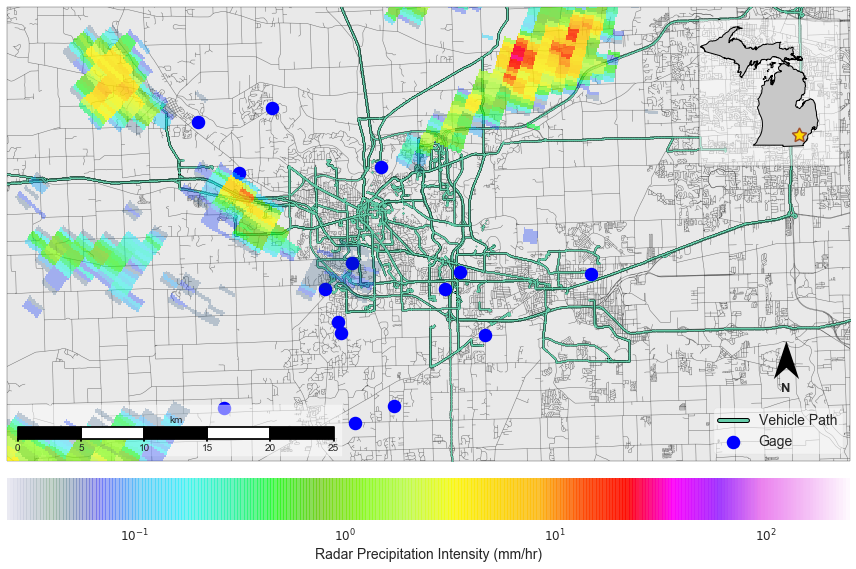

In [13]:
# Create a Stamen Terrain instance.
tiles = cimgt.StamenTerrain()

# Create a GeoAxes in the tile's projection.
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=tiles.crs)

zoom = 8

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([xmin+0.1, xmax-0.1, ymin+0.05, ymax-0.01])

roads.to_crs(tiles.crs.proj4_init).plot(ax=ax, linewidth=0.5, color='k', alpha=0.5, zorder=3)

cmap = cm.gist_ncar
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.log10(np.linspace(1, 10, cmap.N))
my_cmap = ListedColormap(my_cmap)

transformed_extent = tiles.crs.transform_points(ccrs.Geodetic(), np.asarray([xmin, xmax]), np.asarray([ymin, ymax]))

radar_im = ax.imshow(25.4*p_radar.values[0, :, :], cmap=my_cmap,
                     extent=(transformed_extent[:, 0].tolist() + transformed_extent[:, 1].tolist()),
                     origin='lower', zorder=4, norm=LogNorm(vmin=2.5e-2, vmax=250),
                    transform=tiles.crs)

for trip in veh['Trip'].unique():
    g_trip = v_g.loc[trip].sort_index()
    vx, vy = g_trip['Longitude'].values, g_trip['Latitude'].values
    ax.scatter(vx, vy, c='k', s=1.4, zorder=3, transform=ccrs.Geodetic())
    ax.scatter(vx, vy, c='#66cdaa', s=1.1, zorder=3, transform=ccrs.Geodetic())
    
gage_scat = ax.scatter(x, y, c='b', zorder=4, marker='o', s=90, linewidth=4, transform=ccrs.Geodetic(), label='Gage')

cb = fig.colorbar(radar_im, cmap=my_cmap,
                  label='Radar Precipitation Intensity (in/hr)',
                  orientation='horizontal', pad=0.02)
cb.ax.tick_params(labelsize=12) 
cb.set_label('Radar Precipitation Intensity (mm/hr)', size=14)

plt.plot([0], [0], linewidth=3, color='#66cdaa', label='Vehicle Path',
         path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])

legend = ax.legend(frameon=True, loc=4, prop={'size': 14})
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.5)

ax.background_patch.set_facecolor('0.86')
ax.background_patch.set_alpha(0.6)

plt.tight_layout()
add_osgb_scalebar(ax, at_x=(0.075, 0.375), zorder=5)

a = plt.axes([0.81, 0.52, .17, .17], projection=tiles.crs)
a.set_extent(extent_proj, crs=tiles.crs)

michigan.to_crs(tiles.crs.proj4_init).plot(ax=a, alpha=1, facecolor=(200/255, 200/255, 200/255, 1), zorder=2)
a.plot(aa_loc[0], aa_loc[1], marker=(5, 1), markersize=15, mfc='gold', mec='sienna', mew=1.5, zorder=6)

a.background_patch.set_alpha(0.5)
#a.set_frame_on(False)
a.set_clip_on(False)

x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()

ax.arrow(x1-5000,y0+5500,0,1000,fc="k", ec="k", linewidth = 0, head_width=2000, head_length=3000, overhang=0.3)
ax.text(x1-5400, y0+5500, "N", fontsize=13, weight='bold')

plt.savefig('../img/fig1_arrow_r.png', bbox_inches='tight')